# Metadata

```
Course:   DS 5001
Module:   04 Lab
Topic:    NLP and the Pipeline
Author:   R.C. Alvarado

Purpose:  We import a collection of texts and convert to F2. Then we annotate the collection to create an F3-level model.
```

# Set Up

In [1]:
data_home = "../data"
local_lib = "../lib"
source_files = f'{data_home}/gutenberg/austen-melville-set'
data_prefix = 'austen-melville'

In [2]:
OHCO = ['book_id', 'chap_num', 'para_num', 'sent_num', 'token_num']

In [3]:
import pandas as pd
import numpy as np
from glob import glob
import re
import nltk

In [4]:
import sys
sys.path.append(local_lib)

In [5]:
from textparser import TextParser

# Inspect

Since Project Gutenberg texts vary widely in their markup, we define our chunking patterns by hand.

In [6]:
roman = '[IVXLCM]+'
caps = "[A-Z';, -]+"
clip_pats = [
    r"\*\*\*\s*START OF",
    r"\*\*\*\s*END OF"
]
# All are 'chap'and 'm'
ohco_pat_list = [
    (158,   rf"^\s*CHAPTER\s+{roman}\s*$"),
    (946,   rf"^\s*{roman}\s*$"),
    (1212,  rf"^\s*LETTER .* to .*$"),
    (141,   rf"^CHAPTER\s+{roman}$"),
    (121,   rf"^CHAPTER\s+\d+$"),
    (105,   rf"^Chapter\s+\d+$"),
    (1342,  rf"^Chapter\s+\d+$"),
    (161,   rf"^CHAPTER\s+\d+$"),    
    (15422, rf"^\s*CHAPTER\s+{roman}\."),
    (13720, rf"^\s*CHAPTER\s+{roman}\s*$"),
    (13721, rf"^\s*CHAPTER\s+{roman}\s*$"),
    (2701,  rf"^(?:ETYMOLOGY|EXTRACTS|CHAPTER)"),
    (4045,  rf"^\s*CHAPTER\s+{roman}\.\s*$"),
    (34970, rf"^\s*{roman}\.\s*$"),
    (8118,  rf"^\s*{roman}\. .*$"),
    (21816, rf"^CHAPTER\s+{roman}\.?$"),
    (1900,  rf"^CHAPTER "),
    (10712, rf"^CHAPTER\s+{roman}\.\s*$")
]

# Register

We get each file and add to a library `LIB`.

In [7]:
source_file_list = sorted(glob(f"{source_files}/*.*"))

In [8]:
book_data = []
for source_file_path in source_file_list:
    book_id = int(source_file_path.split('-')[-1].split('.')[0].replace('pg',''))
    book_title = source_file_path.split('/')[-1].split('-')[0].replace('_', ' ')
    book_data.append((book_id, source_file_path, book_title))

In [9]:
LIB = pd.DataFrame(book_data, columns=['book_id','source_file_path','raw_title'])\
    .set_index('book_id').sort_index()

In [10]:
LIB

,source_file_path,raw_title
book_id,,
105,../data/gutenberg/austen-melville-set/AUSTEN_J...,AUSTEN JANE PERSUASION
121,../data/gutenberg/austen-melville-set/AUSTEN_J...,AUSTEN JANE NORTHANGER ABBEY
141,../data/gutenberg/austen-melville-set/AUSTEN_J...,AUSTEN JANE MANSFIELD PARK
158,../data/gutenberg/austen-melville-set/AUSTEN_J...,AUSTEN JANE EMMA
161,../data/gutenberg/austen-melville-set/AUSTEN_J...,AUSTEN JANE SENSE AND SENSIBILITY
946,../data/gutenberg/austen-melville-set/AUSTEN_J...,AUSTEN JANE LADY SUSAN
1212,../data/gutenberg/austen-melville-set/AUSTEN_J...,AUSTEN JANE LOVE AND FREINDSHIP SIC
1342,../data/gutenberg/austen-melville-set/AUSTEN_J...,AUSTEN JANE PRIDE AND PREJUDICE
1900,../data/gutenberg/austen-melville-set/MELVILLE...,MELVILLE HERMAN TYPEE A ROMANCE OF THE SOUTH SEAS


## Save Chapter regexes

In [48]:
LIB['chap_regex'] = LIB.index.map(pd.Series({x[0]:x[1] for x in ohco_pat_list}))

In [49]:
LIB

,source_file_path,raw_title,book_len,n_chaps,chap_regex
book_id,,,,,
105,../data/gutenberg/austen-melville-set/AUSTEN_J...,AUSTEN JANE PERSUASION,83624,24,^Chapter\s+\d+$
121,../data/gutenberg/austen-melville-set/AUSTEN_J...,AUSTEN JANE NORTHANGER ABBEY,77601,31,^CHAPTER\s+\d+$
141,../data/gutenberg/austen-melville-set/AUSTEN_J...,AUSTEN JANE MANSFIELD PARK,160378,48,^CHAPTER\s+[IVXLCM]+$
158,../data/gutenberg/austen-melville-set/AUSTEN_J...,AUSTEN JANE EMMA,160925,55,^\s*CHAPTER\s+[IVXLCM]+\s*$
161,../data/gutenberg/austen-melville-set/AUSTEN_J...,AUSTEN JANE SENSE AND SENSIBILITY,119873,50,^CHAPTER\s+\d+$
946,../data/gutenberg/austen-melville-set/AUSTEN_J...,AUSTEN JANE LADY SUSAN,23116,41,^\s*[IVXLCM]+\s*$
1212,../data/gutenberg/austen-melville-set/AUSTEN_J...,AUSTEN JANE LOVE AND FREINDSHIP SIC,33265,24,^\s*LETTER .* to .*$
1342,../data/gutenberg/austen-melville-set/AUSTEN_J...,AUSTEN JANE PRIDE AND PREJUDICE,122126,61,^Chapter\s+\d+$
1900,../data/gutenberg/austen-melville-set/MELVILLE...,MELVILLE HERMAN TYPEE A ROMANCE OF THE SOUTH SEAS,108021,34,^CHAPTER


In [45]:
{x[0]:x[1] for x in ohco_pat_list}

{158: '^\\s*CHAPTER\\s+[IVXLCM]+\\s*$',
 946: '^\\s*[IVXLCM]+\\s*$',
 1212: '^\\s*LETTER .* to .*$',
 141: '^CHAPTER\\s+[IVXLCM]+$',
 121: '^CHAPTER\\s+\\d+$',
 105: '^Chapter\\s+\\d+$',
 1342: '^Chapter\\s+\\d+$',
 161: '^CHAPTER\\s+\\d+$',
 15422: '^\\s*CHAPTER\\s+[IVXLCM]+\\.',
 13720: '^\\s*CHAPTER\\s+[IVXLCM]+\\s*$',
 13721: '^\\s*CHAPTER\\s+[IVXLCM]+\\s*$',
 2701: '^(?:ETYMOLOGY|EXTRACTS|CHAPTER)',
 4045: '^\\s*CHAPTER\\s+[IVXLCM]+\\.\\s*$',
 34970: '^\\s*[IVXLCM]+\\.\\s*$',
 8118: '^\\s*[IVXLCM]+\\. .*$',
 21816: '^CHAPTER\\s+[IVXLCM]+\\.?$',
 1900: '^CHAPTER ',
 10712: '^CHAPTER\\s+[IVXLCM]+\\.\\s*$'}

## Tokenize

We tokenize each book and add each `TOKENS` table to a list to be concatenated into a single `CORPUS`.

In [12]:
books = []
for pat in ohco_pat_list:
    
    book_id, chap_regex = pat
    print("Tokenizing", book_id, LIB.loc[book_id].raw_title)
    ohco_pats = [('chap', chap_regex, 'm')]
    src_file_path = LIB.loc[book_id].source_file_path
    
    text = TextParser(src_file_path, ohco_pats=ohco_pats, clip_pats=clip_pats, use_nltk=True)
    text.verbose = False
    text.strip_hyphens = True
    text.strip_whitespace = True
    text.import_source().parse_tokens();
    text.TOKENS['book_id'] = book_id
    text.TOKENS = text.TOKENS.reset_index().set_index(['book_id'] + text.OHCO)
    
    books.append(text.TOKENS)

Tokenizing 158 AUSTEN JANE EMMA
Tokenizing 946 AUSTEN JANE LADY SUSAN
Tokenizing 1212 AUSTEN JANE LOVE AND FREINDSHIP SIC 
Tokenizing 141 AUSTEN JANE MANSFIELD PARK
Tokenizing 121 AUSTEN JANE NORTHANGER ABBEY
Tokenizing 105 AUSTEN JANE PERSUASION
Tokenizing 1342 AUSTEN JANE PRIDE AND PREJUDICE
Tokenizing 161 AUSTEN JANE SENSE AND SENSIBILITY
Tokenizing 15422 MELVILLE HERMAN ISRAEL POTTER HIS FIFTY YEARS OF EXILE
Tokenizing 13720 MELVILLE HERMAN MARDI AND A VOYAGE THITHER VOL I
Tokenizing 13721 MELVILLE HERMAN MARDI AND A VOYAGE THITHER VOL II
Tokenizing 2701 MELVILLE HERMAN MOBY DICK OR THE WHALE
Tokenizing 4045 MELVILLE HERMAN OMOO ADVENTURES IN THE SOUTH SEAS
Tokenizing 34970 MELVILLE HERMAN PIERRE OR THE AMBIGUITIES
Tokenizing 8118 MELVILLE HERMAN REDBURN HIS FIRST VOYAGE BEING THE SAILOR BOY CONFESSIONS AND REMINISCENCES OF THE SON OF A GENTLEMAN IN THE MERCHANT NAVY
Tokenizing 21816 MELVILLE HERMAN THE CONFIDENCE MAN HIS MASQUERADE
Tokenizing 1900 MELVILLE HERMAN TYPEE A ROMANCE O

# Create Corpus

In [13]:
CORPUS = pd.concat(books).sort_index()

In [14]:
CORPUS

pos_tuple  pos  \
book_id chap_id para_num sent_num token_num                             
105     1       0        0        0                   (Sir, NNP)  NNP   
                                  1                (Walter, NNP)  NNP   
                                  2               (Elliot,, NNP)  NNP   
                                  3                     (of, IN)   IN   
                                  4              (Kellynch, NNP)  NNP   
...                                                          ...  ...   
34970   114     0        50       6                    (The, DT)   DT   
                                  7          (Ambiguities,, NNP)  NNP   
                                  8                     (by, IN)   IN   
                                  9                (Herman, NNP)  NNP   
                                  10             (Melville, NNP)  NNP   

                                                token_str     term_str  
book_id chap_id para_num sent_num token_num                             
105     1       0        0        0                   Sir          sir  
                                  1                Walter       walter  
                                  2               Elliot,       elliot  
                                  3                    of           of  
                                  4              Kellynch     kellynch  
...                                                   ...          ...  
34970   114     0        50       6                   The          the  
                                  7          Ambiguities,  ambiguities  
                                  8                    by           by  
                                  9                Herman       herman  
                                  10             Melville     melville  

[1984504 rows x 4 columns]

## Extract some features for `LIB`

In [15]:
LIB['book_len'] = CORPUS.groupby('book_id').term_str.count()

In [16]:
LIB.sort_values('book_len')

,source_file_path,raw_title,book_len
book_id,,,
946,../data/gutenberg/austen-melville-set/AUSTEN_J...,AUSTEN JANE LADY SUSAN,23116
1212,../data/gutenberg/austen-melville-set/AUSTEN_J...,AUSTEN JANE LOVE AND FREINDSHIP SIC,33265
15422,../data/gutenberg/austen-melville-set/MELVILLE...,MELVILLE HERMAN ISRAEL POTTER HIS FIFTY YEARS ...,65516
121,../data/gutenberg/austen-melville-set/AUSTEN_J...,AUSTEN JANE NORTHANGER ABBEY,77601
105,../data/gutenberg/austen-melville-set/AUSTEN_J...,AUSTEN JANE PERSUASION,83624
21816,../data/gutenberg/austen-melville-set/MELVILLE...,MELVILLE HERMAN THE CONFIDENCE MAN HIS MASQUERADE,95315
13720,../data/gutenberg/austen-melville-set/MELVILLE...,MELVILLE HERMAN MARDI AND A VOYAGE THITHER VOL I,96878
13721,../data/gutenberg/austen-melville-set/MELVILLE...,MELVILLE HERMAN MARDI AND A VOYAGE THITHER VOL II,102092
4045,../data/gutenberg/austen-melville-set/MELVILLE...,MELVILLE HERMAN OMOO ADVENTURES IN THE SOUTH SEAS,102352


In [17]:
LIB['n_chaps'] = CORPUS.reset_index()[['book_id','chap_id']]\
    .drop_duplicates()\
    .groupby('book_id').chap_id.count()

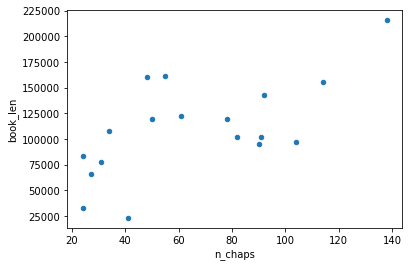

In [18]:
LIB.plot.scatter('n_chaps','book_len');

# Exract VOCAB

Extract a vocabulary from the CORPUS as a whole

## Handle Anomalies

NLTK's POS tagger is not perfect -- note the classification of punctuation as nouns, verbs, etc. We remove these from our corups.

In [19]:
CORPUS[CORPUS.term_str == '']

pos_tuple  pos token_str term_str
book_id chap_id para_num sent_num token_num                                  
105     3       0        5        12         (", NNP)  NNP         "         
                         55       22         (", VBZ)  VBZ         "         
        6       0        93       0          (),, NN)   NN        ),         
        14      0        25       9          (", VBP)  VBP         "         
        20      0        22       14          (", VB)   VB         "         
...                                               ...  ...       ...      ...
34970   79      0        44       15          (&, CC)   CC         &         
        80      0        50       24         (_., NN)   NN        _.         
        83      0        44       0          (),, NN)   NN        ),         
                         45       0          ();, NN)   NN        );         
        111     0        10       3           (&, CC)   CC         &         

[468 rows x 4 columns]

In [20]:
CORPUS[CORPUS.term_str == ''].token_str.value_counts()

"        218
*        112
|         85
&          9
*****      7
),         5
+          4
'          3
.'         2
?"         2
"*         2
."         1
_.         1
£          1
'_         1
",         1
&.         1
,"         1
"...       1
'*         1
,'         1
::         1
!"         1
'"         1
";         1
_          1
);         1
....       1
[*         1
***        1
Name: token_str, dtype: int64

In [21]:
CORPUS = CORPUS[CORPUS.term_str != '']

In [22]:
VOCAB = CORPUS.term_str.value_counts().to_frame('n').sort_index()
VOCAB.index.name = 'term_str'
VOCAB['n_chars'] = VOCAB.index.str.len()
VOCAB['p'] = VOCAB.n / VOCAB.n.sum()
VOCAB['i'] = -np.log2(VOCAB.p)

# Annotate VOCAB

## Get Max POS

Get the most frequently associated part-of-space category for each word.

In [23]:
VOCAB['max_pos'] = CORPUS[['term_str','pos']].value_counts().unstack(fill_value=0).idxmax(1)

## Compute POS ambiguity

How many POS categories are associated with each word?

In [24]:
TPM = CORPUS[['term_str','pos']].value_counts().unstack()

In [25]:
# TPM

In [26]:
VOCAB['n_pos'] = TPM.count(1)

In [27]:
VOCAB['cat_pos'] = CORPUS[['term_str','pos']].value_counts().to_frame('n').reset_index()\
    .groupby('term_str').pos.apply(lambda x: set(x))

In [28]:
VOCAB

,n,n_chars,p,i,max_pos,n_pos,cat_pos
term_str,,,,,,,
0,2,1,1.008204e-06,19.919781,CD,1,{CD}
1,21,1,1.058614e-05,16.527464,CD,3,"{NNP, JJ, CD}"
10,6,2,3.024611e-06,18.334819,CD,1,{CD}
100,2,3,1.008204e-06,19.919781,CD,1,{CD}
1000,2,4,1.008204e-06,19.919781,CD,1,{CD}
...,...,...,...,...,...,...,...
æneas,1,5,5.041019e-07,20.919781,NNP,1,{NNP}
æniad,1,5,5.041019e-07,20.919781,NN,1,{NN}
æson,2,4,1.008204e-06,19.919781,NN,1,{NN}


In [29]:
# nltk.help.upenn_tagset()

## Add Stopwords

We use NLTK's built in stopword list for English. Note that we can add and subtract from this list, or just create our own list and keep it in our data model.

In [30]:
sw = pd.DataFrame(nltk.corpus.stopwords.words('english'), columns=['term_str'])
sw = sw.reset_index().set_index('term_str')
sw.columns = ['dummy']
sw.dummy = 1

In [31]:
sw.sample(10)

,dummy
term_str,
being,1
won,1
how,1
before,1
my,1
she,1
of,1
yours,1
some,1


In [32]:
VOCAB['stop'] = VOCAB.index.map(sw.dummy)
VOCAB['stop'] = VOCAB['stop'].fillna(0).astype('int')

In [33]:
VOCAB[VOCAB.stop == 1].sample(10)

,n,n_chars,p,i,max_pos,n_pos,cat_pos,stop
term_str,,,,,,,,
than,3821,4,0.001926,9.020047,IN,7,"{VBZ, VBD, IN, NNP, VB, NNS, NN}",1
haven,16,5,0.000008,16.919781,NN,4,"{VBZ, RB, JJ, NN}",1
through,1537,7,0.000775,10.333880,IN,10,"{VBD, RP, IN, NNP, JJ, VB, RB, NNS, VBP, NN}",1
they,7783,4,0.003923,7.993671,PRP,14,"{EX, VBZ, MD, PRP, POS, NNP, CC, JJ, VB, RB, V...",1
why,871,3,0.000439,11.153252,WRB,13,"{VBZ, MD, IN, POS, NNP, JJ, VB, WRB, RB, CD, N...",1
most,2776,4,0.001399,9.480989,RBS,11,"{RBS, VBZ, JJS, IN, NNP, JJ, VB, RB, VBN, NNS,...",1
further,351,7,0.000177,12.464454,JJ,10,"{RBR, NNP, JJR, JJ, RB, VB, VBN, NNS, VBP, NN}",1
is,13123,2,0.006615,7.239971,VBZ,15,"{VBZ, VBN, MD, VBD, RP, IN, NNP, CC, JJ, VB, R...",1
yours,224,5,0.000113,13.112426,NN,13,"{VBZ, PRP$, RP, PRP, NNP, CC, JJ, VB, RB, FW, ...",1


## Interlude: Stopword Stats

In [34]:
a = VOCAB.groupby('stop').n_chars.mean()
b = VOCAB.groupby('stop').n_pos.mean().sort_values(ascending=False)

In [35]:
pd.concat([a,b], 1)

,n_chars,n_pos
stop,,
0,7.867953,2.133396
1,3.766423,12.401460


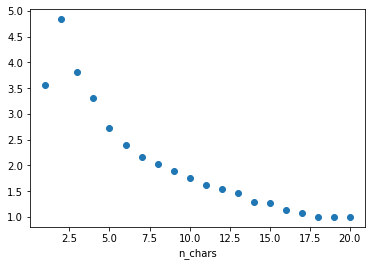

In [36]:
VOCAB.groupby('n_chars').n_pos.mean()\
    .sort_values(ascending=False).plot(style='o');

Curious that stopwords would have such variability.

In [37]:
VOCAB[VOCAB.stop == True].sort_values('n_pos', ascending=False)[['n_pos','cat_pos']].head(20)

,n_pos,cat_pos
term_str,,
you,25,"{EX, PRP$, VBD, FW, NNS, CD, RBR, JJ, WDT, RB,..."
now,22,"{VBD, FW, NNS, DT, RBR, JJ, RB, PRP, CC, VBP, ..."
me,22,"{VBD, FW, NNS, CD, RBS, RBR, JJ, RB, JJS, PRP,..."
that,21,"{EX, VBD, NNS, DT, JJ, WDT, RB, WP, PRP, CC, V..."
here,21,"{EX, PRP$, VBD, NNS, JJ, RB, PRP, CC, WRB, VBP..."
what,20,"{VBD, FW, NNS, CD, DT, JJ, WDT, RB, WP, WRB, V..."
not,20,"{VBD, FW, NNS, DT, JJ, RB, PRP, CC, VBP, JJR, ..."
him,20,"{PRP$, VBD, FW, NNS, RBR, JJ, RB, PRP, CC, VBP..."
there,20,"{EX, VBD, NNS, JJ, WDT, RB, WRB, VBG, VBP, VBZ..."


Anyway . . .

## Add Stems

In [42]:
from nltk.stem.porter import PorterStemmer
stemmer1 = PorterStemmer()
VOCAB['stem_porter'] = VOCAB.apply(lambda x: stemmer1.stem(x.name), 1)

from nltk.stem.snowball import SnowballStemmer
stemmer2 = SnowballStemmer("english")
VOCAB['stem_snowball'] = VOCAB.apply(lambda x: stemmer2.stem(x.name), 1)

from nltk.stem.lancaster import LancasterStemmer
stemmer3 = LancasterStemmer()
VOCAB['stem_lancaster'] = VOCAB.apply(lambda x: stemmer3.stem(x.name), 1)

In [39]:
VOCAB.sample(10)

,n,n_chars,p,i,max_pos,n_pos,cat_pos,stop,stem_porter,stem_snowball,stem_lancaster
term_str,,,,,,,,,,,
mackintosh,2,10,1.008204e-06,19.919781,NNP,1,{NNP},0,mackintosh,mackintosh,mackintosh
ablutions,6,9,3.024611e-06,18.334819,NNS,2,"{NNS, NN}",0,ablut,ablut,ablut
greeks,3,6,1.512306e-06,19.334819,NNP,1,{NNP},0,greek,greek,greek
crews,50,5,2.520509e-05,15.275925,NNS,3,"{NNS, NNP, NN}",0,crew,crew,crew
corps,15,5,7.561528e-06,17.012891,NN,3,"{VBZ, NNP, NN}",0,corp,corp,corp
retaliate,1,9,5.041019e-07,20.919781,VB,1,{VB},0,retali,retali,reta
cleansed,3,8,1.512306e-06,19.334819,VBD,3,"{VBN, JJ, VBD}",0,cleans,cleans,cleans
herods,1,6,5.041019e-07,20.919781,NNP,1,{NNP},0,herod,herod,herod
comprehensiveness,4,17,2.016408e-06,18.919781,NN,1,{NN},0,comprehens,comprehens,comprehend


In [43]:
VOCAB[VOCAB.stem_porter != VOCAB.stem_snowball]

,n,n_chars,p,i,max_pos,n_pos,cat_pos,stop,stem_porter,stem_snowball,stem_lancaster
term_str,,,,,,,,,,,
abandonedly,2,11,1.008204e-06,19.919781,RB,1,{RB},0,abandonedli,abandon,abandon
abhorringly,1,11,5.041019e-07,20.919781,RB,1,{RB},0,abhorringli,abhor,abhor
abjectly,2,8,1.008204e-06,19.919781,RB,1,{RB},0,abjectli,abject,abject
abjectus,1,8,5.041019e-07,20.919781,NNP,1,{NNP},0,abjectu,abjectus,abject
aboundingly,1,11,5.041019e-07,20.919781,RB,1,{RB},0,aboundingli,abound,abound
...,...,...,...,...,...,...,...,...,...,...,...
yes,915,3,4.612532e-04,11.082153,NN,20,"{PRP$, VBD, FW, NNS, JJ, RB, PRP, CC, VBP, JJR...",0,ye,yes,ye
yous,1,4,5.041019e-07,20.919781,NN,1,{NN},0,you,yous,yo
yrs,4,3,2.016408e-06,18.919781,NNP,2,"{NNP, NN}",0,yr,yrs,yr


## Save

In [40]:
out_path = f'{data_home}/output/{data_prefix}'

In [41]:
LIB.to_csv(f'{out_path}-LIB.csv')
VOCAB.to_csv(f'{out_path}-VOCAB.csv')
CORPUS.to_csv(f'{out_path}-CORPUS.csv')